Source codes for Python Machine Learning By Example 4th Edition (Packt Publishing)

Chapter 15 Making Decisions in Complex Environments with Reinforcement Learning

Author: Yuxi (Hayden) Liu (yuxi.liu.ece@gmail.com)

# Performing Monte Carlo learning

## Simulating the Blackjack environment

In [1]:
import gymnasium as gym

env = gym.make('Blackjack-v1')

env.reset(seed=0)


((11, 10, 0), {})

In [2]:
env.step(1)


((12, 10, 0), 0.0, False, False, {})

In [3]:
env.step(1)


((13, 10, 0), 0.0, False, False, {})

In [4]:
env.step(0)

((13, 10, 0), -1.0, True, False, {})

## Performing Monte Carlo policy evaluation

In [5]:
def run_episode(env, hold_score):
    state, _ = env.reset()
    rewards = []
    states = [state]
    while True:
        action = 1 if state[0] < hold_score else 0
        state, reward, terminated, truncated, info = env.step(action)
        is_done = terminated or truncated
        states.append(state)
        rewards.append(reward)
        if is_done:
            break
    return states, rewards


In [6]:
from collections import defaultdict

def mc_prediction_first_visit(env, hold_score, gamma, n_episode):
    V = defaultdict(float)
    N = defaultdict(int)
    for episode in range(n_episode):
        states_t, rewards_t = run_episode(env, hold_score)
        return_t = 0
        G = {}
        for state_t, reward_t in zip(states_t[1::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[state_t] = return_t
        for state, return_t in G.items():
            if state[0] <= 21:
                V[state] += return_t
                N[state] += 1
    for state in V:
        V[state] = V[state] / N[state]
    return V


In [7]:
gamma = 1
hold_score = 18
n_episode = 500000

value = mc_prediction_first_visit(env, hold_score, gamma, n_episode)

print(value)

print('Number of states:', len(value))

defaultdict(<class 'float'>, {(19, 3, 0): 0.41360718870346597, (21, 10, 0): 0.885656836461126, (17, 10, 0): -0.3887961417176776, (18, 10, 1): -0.255662319835278, (17, 10, 1): -0.2840192806822395, (14, 10, 0): -0.29505716207128446, (13, 10, 0): -0.2743235693191795, (14, 2, 0): -0.15767230169050714, (13, 2, 0): -0.14885245901639343, (19, 9, 0): 0.2962264150943396, (19, 10, 0): -0.016647081864473168, (12, 10, 0): -0.24741546832491254, (21, 10, 1): 0.9164161849710982, (17, 9, 0): -0.28319882611885544, (9, 9, 0): -0.06857523302263649, (15, 5, 0): -0.13894663894663895, (11, 5, 0): 0.2210193955796121, (13, 9, 0): -0.1656071201525747, (7, 9, 0): -0.36635706914344685, (20, 5, 0): 0.6822101002991378, (16, 9, 0): -0.2875864579541318, (10, 9, 0): 0.09758713136729223, (19, 4, 0): 0.42080378250591016, (15, 10, 0): -0.3165645216207014, (19, 1, 0): -0.10504311471126208, (5, 10, 0): -0.38997214484679665, (21, 9, 1): 0.9908872901678657, (20, 10, 0): 0.43320559664914, (16, 10, 0): -0.3259860788863109, (2

## Performing on-policy Monte Carlo control

In [8]:
import torch

def run_episode(env, Q, n_action):
    state, _ = env.reset()
    rewards = []
    actions = []
    states = []
    action = torch.randint(0, n_action, [1]).item()
    while True:
        actions.append(action)
        states.append(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_done = terminated or truncated
        rewards.append(reward)
        if is_done:
            break
        action = torch.argmax(Q[state]).item()
    return states, actions, rewards


In [9]:
def mc_control_on_policy(env, gamma, n_episode):
    n_action = env.action_space.n
    G_sum = defaultdict(float)
    N = defaultdict(int)
    Q = defaultdict(lambda: torch.empty(n_action))
    for episode in range(n_episode):
        states_t, actions_t, rewards_t = run_episode(env, Q, n_action)
        return_t = 0
        G = {}
        for state_t, action_t, reward_t in zip(states_t[::-1], actions_t[::-1], rewards_t[::-1]):
            return_t = gamma * return_t + reward_t
            G[(state_t, action_t)] = return_t
        for state_action, return_t in G.items():
            state, action = state_action
            if state[0] <= 21:
                G_sum[state_action] += return_t
                N[state_action] += 1
                Q[state][action] = G_sum[state_action] / N[state_action]
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy


In [10]:
gamma = 1
n_episode = 500000

optimal_Q, optimal_policy = mc_control_on_policy(env, gamma, n_episode)

print(optimal_policy)

{(20, 1, 0): 0, (20, 8, 0): 0, (20, 6, 1): 0, (15, 9, 0): 1, (15, 8, 0): 1, (10, 8, 0): 1, (19, 9, 0): 0, (19, 7, 0): 0, (16, 7, 0): 1, (14, 10, 0): 1, (17, 10, 1): 1, (19, 1, 0): 0, (16, 1, 0): 1, (6, 1, 0): 1, (12, 10, 1): 1, (13, 10, 0): 1, (18, 1, 0): 0, (18, 1, 1): 0, (19, 8, 0): 0, (16, 6, 0): 0, (14, 6, 0): 0, (20, 3, 0): 0, (20, 9, 0): 0, (12, 9, 0): 1, (20, 10, 0): 0, (20, 2, 0): 0, (18, 5, 0): 0, (20, 2, 1): 0, (9, 7, 0): 1, (13, 6, 0): 0, (15, 10, 0): 1, (10, 10, 0): 1, (17, 9, 0): 0, (18, 10, 0): 0, (13, 9, 0): 1, (12, 3, 0): 1, (15, 4, 0): 0, (16, 7, 1): 1, (15, 3, 0): 0, (9, 3, 0): 1, (14, 6, 1): 1, (17, 3, 0): 0, (7, 3, 0): 1, (17, 8, 1): 1, (20, 7, 0): 0, (16, 10, 0): 1, (12, 10, 0): 1, (14, 5, 0): 0, (13, 2, 0): 0, (13, 9, 1): 1, (19, 4, 0): 0, (21, 4, 1): 0, (12, 4, 0): 0, (21, 9, 1): 0, (6, 6, 0): 1, (16, 10, 1): 1, (7, 1, 0): 1, (12, 8, 0): 1, (16, 8, 0): 1, (21, 9, 0): 0, (14, 9, 0): 1, (17, 10, 0): 0, (21, 6, 1): 0, (18, 3, 0): 0, (19, 3, 1): 0, (19, 2, 0): 0, (17

In [11]:
def simulate_hold_episode(env, hold_score):
    state, _ = env.reset()
    while True:
        action = 1 if state[0] < hold_score else 0
        state, reward, terminated, truncated, info = env.step(action)
        is_done = terminated or truncated
        if is_done:
            return reward
        

In [12]:
def simulate_episode(env, policy):
    state, _ = env.reset()
    while True:
        action = policy[state]
        state, reward, terminated, truncated, info = env.step(action)
        is_done = terminated or truncated
        if is_done:
            return reward
        

In [13]:
n_episode = 100000
hold_score = 18
n_win_opt = 0
n_win_hold = 0

for _ in range(n_episode):
    reward = simulate_hold_episode(env, hold_score)
    if reward == 1:
        n_win_hold += 1
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_opt += 1


In [14]:
print(f'Winning probability under the simple policy: {n_win_hold/n_episode}')
print(f'Winning probability under the optimal policy: {n_win_opt/n_episode}')

Winning probability under the simple policy: 0.401
Winning probability under the optimal policy: 0.43187


# Solving the Blackjack problem with the Q-learning algorithm

## Developing the Q-learning algorithm

In [15]:
def epsilon_greedy_policy(n_action, epsilon, state, Q):
    probs = torch.ones(n_action) * epsilon / n_action
    best_action = torch.argmax(Q[state]).item()
    probs[best_action] += 1.0 - epsilon
    action = torch.multinomial(probs, 1).item()
    return action


In [16]:
def q_learning(env, gamma, n_episode, alpha, epsilon, final_epsilon):
    n_action = env.action_space.n
    Q = defaultdict(lambda: torch.zeros(n_action))
    epsilon_decay = epsilon / (n_episode / 2)  
    for episode in range(n_episode):
        state, _ = env.reset()
        is_done = False
        epsilon = max(final_epsilon, epsilon - epsilon_decay)

        while not is_done:
            action = epsilon_greedy_policy(n_action, epsilon, state, Q)
            next_state, reward, terminated, truncated, info = env.step(action)
            is_done = terminated or truncated
            delta = reward + gamma * torch.max(Q[next_state]) - Q[state][action]
            Q[state][action] += alpha * delta
            total_reward_episode[episode] += reward
            if is_done:
                break
            state = next_state
    policy = {}
    for state, actions in Q.items():
        policy[state] = torch.argmax(actions).item()
    return Q, policy


In [17]:
n_episode = 10000
epsilon = 1.0
final_epsilon = 0.1

gamma = 1
alpha = 0.003

total_reward_episode = [0] * n_episode

optimal_Q, optimal_policy = q_learning(env, gamma, n_episode, alpha, epsilon, final_epsilon)


In [18]:
rolling_avg_reward = [total_reward_episode[0]]
for i, reward in enumerate(total_reward_episode[1:], 1):
    rolling_avg_reward.append((rolling_avg_reward[-1]*i + reward)/(i+1))

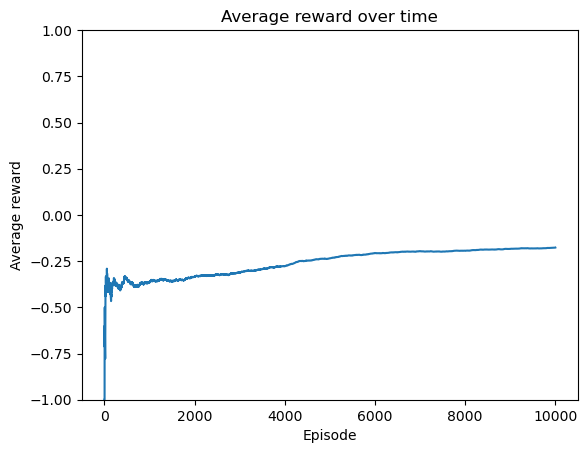

In [19]:
import matplotlib.pyplot as plt
plt.plot(rolling_avg_reward)
plt.title('Average reward over time')
plt.xlabel('Episode')
plt.ylabel('Average reward')
plt.ylim([-1, 1])
plt.show()

In [20]:
n_episode = 100000
n_win_opt = 0

for _ in range(n_episode):
    reward = simulate_episode(env, optimal_policy)
    if reward == 1:
        n_win_opt += 1

In [21]:
print(f'Winning probability under the optimal policy: {n_win_opt/n_episode}')

Winning probability under the optimal policy: 0.42398


---

Readers may ignore the next cell.

In [22]:
!jupyter nbconvert --to python ch15_part2.ipynb --TemplateExporter.exclude_input_prompt=True

[NbConvertApp] Converting notebook ch15_part2.ipynb to python
[NbConvertApp] Writing 6715 bytes to ch15_part2.py
